# Regression Simulation

Here, we will create a very simple regression simulation, modeling the ecological succession between 4 species
across two different environments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Let's first establish a ground truth model.  We can construct this using `chain_interactions`.  We'll need to first define a gradient, and the distributions of microbes along that gradient.  For now, we are assuming that those distributions are all Gaussian with equal variance.

In [2]:
from corrome.sim import chain_interactions
gradient = np.linspace(0, 36, 100)
mu = np.arange(10, 30, 5) 
sigma = np.array([3]*len(mu))
microbial_truth = chain_interactions(gradient, mu, sigma)

Let's spend a little time understanding what exactly we have generated.  



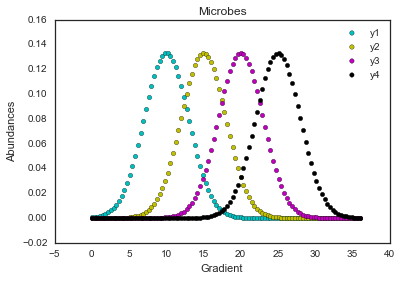

In [3]:
from cycler import cycler
fig, ax = plt.subplots()
ax.scatter(gradient, microbial_truth[:, 0], label='y1', c='c')
ax.scatter(gradient, microbial_truth[:, 1], label='y2', c='y')
ax.scatter(gradient, microbial_truth[:, 2], label='y3', c='m')
ax.scatter(gradient, microbial_truth[:, 3], label='y4', c='k')
ax.set_title('Microbes')
ax.set_ylabel('Abundances')
ax.set_xlabel('Gradient')
ax.legend()

Let's add in an confounding covariate - suppose that there were enzymes introduced that allowed for the intermediates from `y1` to be directly consumed by `y4`.  This will give `y2` and `y3` a slight disadvantage - say that it allows the `y1` and `y4` to grow 100 fold.  We'll model this process using a perturbation.

In [4]:
from skbio.stats.composition import perturb
confounder = np.array([100, 1, 1, 100])
altered_truth = np.vstack([
    perturb(microbial_truth[i, :], confounder)
    for i in range(len(gradient))])
microbial_truth = np.vstack((microbial_truth, altered_truth))

We can see here that each microbe has an optimal abundance along certain portions of the gradient.  We'll want to calculate the correlations between these microbes.  If you correlation the log ratios of the species vs the gradient, you will note that there are nice linear relationships.

We'll want to perform some linear regression so that we can verify the slopes.  This will require formulating the
indepedent and response variables.

In [5]:
confounder = np.array([0] * len(gradient) + [1] * len(gradient))
intercept = np.array([1] * len(gradient) * 2)
gradient = np.hstack((gradient, gradient))
metadata = np.vstack((intercept, confounder, gradient)).T

Now let's compute the linear regressions.

In [6]:
from statsmodels.regression.linear_model import OLS

y1 = microbial_truth[:, 0]
y2 = microbial_truth[:, 1]
y3 = microbial_truth[:, 2]
y4 = microbial_truth[:, 3]
b1 = np.log(np.sqrt((y1*y2)) / np.sqrt((y3*y4)))
b2 = np.log(y1/y2)/np.sqrt(2)
b3 = np.log(y3/y4)/np.sqrt(2)
res1 = OLS(endog=b1, exog=metadata).fit()
res2 = OLS(endog=b2, exog=metadata).fit()
res3 = OLS(endog=b3, exog=metadata).fit()

Now let's try to visualize these relationships and calculate the slopes.

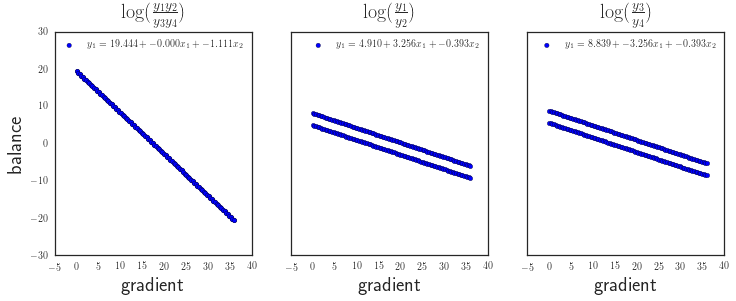

In [7]:
from matplotlib import rc
rc('text', usetex=True)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].scatter(gradient, b1, label=r'$y_1=%1.3f + %1.3f x_1 + %1.3f x_2$' % (tuple(res1.params)))
ax[0].set_title(r'$\log(\frac{y_1 y_2}{y_3 y_4})$', fontsize=20, rotation=0)
ax[0].set_xlabel('gradient', fontsize=20)
ax[0].set_ylabel('balance', fontsize=20)
ax[0].legend()
ax[1].scatter(gradient, b2, label=r'$y_1=%1.3f + %1.3f x_1 + %1.3f x_2$' % (tuple(res2.params)))
ax[1].set_title(r'$\log(\frac{y_1}{y_2})$', fontsize=20, rotation=0)
ax[1].set_xlabel('gradient', fontsize=20)
ax[1].legend()
ax[2].scatter(gradient, b3, label=r'$y_1=%1.3f + %1.3f x_1 + %1.3f x_2$' % (tuple(res3.params)))
ax[2].set_title(r'$\log(\frac{y_3}{y_4})$', fontsize=20, rotation=0)
ax[2].set_xlabel('gradient', fontsize=20)
ax[2].legend()

Now we have our ground truth model - let's now try to simulate the process of sampling from this environment.
We'll simulate the following processes

1. Closure (convert the absolute abundances into proportions).
2. Multiplicative noise (modeling stochastic growth/death processes).  
3. Additive noise (modeling the introduction of contaminates).  
4. Sampling noise (modeling errors from sequencing depth and counting)

# Closure

Since we can rarely observe the entire environment to begin with, we can only infer the proportions.
Given this, we will convert the absolute abundances of the ground truth model into proportions.  We'll 
be using these proportions to generate the counts in the multinomial sampling process.

In [8]:
from skbio.stats.composition import closure
microbial_table = closure(microbial_truth)

# Multiplicative noise

Here we will model the multiplicative noise using an ilr normal distribution.  This will be done using the `compositional_noise` function.  For starters, we will assume that standard deviation is very small, around 0.1.  In addition, we'll assume that the noise sources aren't correlated (i.e. the noise in `y1` doesn't impact `y2`.)

Since we are dealing with probabilities now, the data that we dealing with actually live in the probability simplex $S^4$.  Note that $S^4$ only has three dimensions (i.e. $S^4 \simeq R^3$).  This is why we specify our covariance matrix to be 3x3.

We will also want to control our random seed so that we can have reproducible results.

In [9]:
from corrome.sim import compositional_noise
from numpy.random import RandomState
rng = RandomState(0)
cov = np.eye(3)
m_noise = compositional_noise(cov, nsamp=len(gradient), rng=rng)

We'll want to use the compositional communtative operation in this case. This can be done using the `perturb` operation.  

In [10]:
from skbio.stats.composition import perturb
microbial_table = np.vstack([
    perturb(microbial_table[i, :], m_noise[i, :])
    for i in range(len(gradient))])

Let's plot the microbial abundances together to see what the modified proportions look like.

In [11]:
def prettify_legend(ax):
    # Helper function for making axes pretty
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

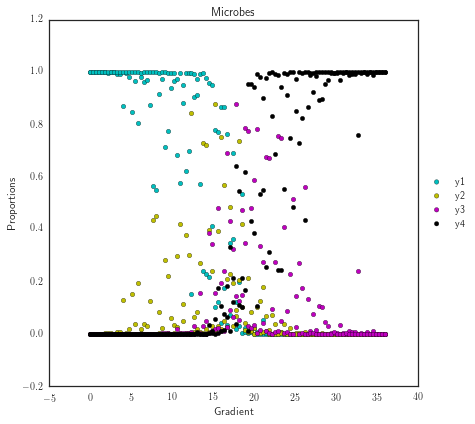

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(gradient, microbial_table[:, 0], label='y1', c='c')
ax.scatter(gradient, microbial_table[:, 1], label='y2', c='y')
ax.scatter(gradient, microbial_table[:, 2], label='y3', c='m')
ax.scatter(gradient, microbial_table[:, 3], label='y4', c='k')
ax.set_title('Microbes')
ax.set_ylabel('Proportions')
ax.set_xlabel('Gradient')
prettify_legend(ax)

plt.tight_layout()

Note that we are dealing with proportions, which is why some of the species are approaching 1 at the ends of the gradient.

# Additive noise

Here we will be modeling the contaminants as an exponential urn.  We will introduce 100 contaminants that are exponentially distributed.  Later, we will be drawing samples that on average have 10000 reads.  So we'll want the smallest value to be around 1/10000.

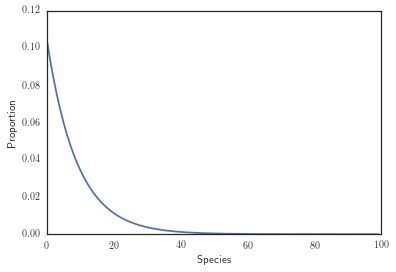

In [13]:
from scipy.stats import expon
x = np.linspace(0, 11, 100)
contaminant_urn = closure(expon.pdf(x))
plt.plot(contaminant_urn)
plt.xlabel('Species')
plt.ylabel('Proportion')

Now we will add these contaminants into our ground truth microbial model.  To do this, we'll directly concatenate these species distributions directly to the exising microbial proportions.

In [14]:
contaminant_urns = np.repeat(np.expand_dims(contaminant_urn, axis=0),
                             microbial_table.shape[0], axis=0)
microbial_table = np.hstack((microbial_table, contaminant_urns))
microbial_table = closure(microbial_table)

# Sampling noise

Now that we have our urns calculated across all of our samples, now we can simulate the process of sampling these urns.

There are two steps to this process - calculating the sequencing depth and counting the species / molecules within an urn.  To simulate the sequencing depth, we'll assume that it follows a Poisson process.  We can then randomly generate the sequencing depths using a Poisson random variable.  Good sequencing depths are typically above 10k reads, so we'll set our Poisson parameter $\lambda=10000$.  Once we have the sequencing depths, we can generate the counts using a multinomial.  All of this can be done using the `multinomial_sample` function. 

In [15]:
from corrome.sim import multinomial_sample
microbial_table = multinomial_sample(microbial_table, lam=10000)

# Summary

Let's plot the presence and absence of microbes and molecules to see the how the tables turned out.

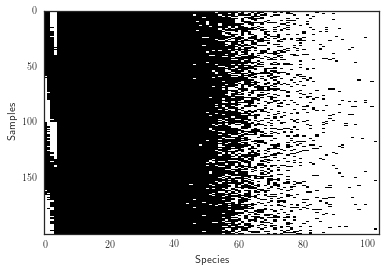

In [16]:
plt.imshow(microbial_table>0, aspect='auto', interpolation='nearest')
plt.xlabel('Species')
plt.ylabel('Samples')

Just for kicks, let's plot the log ratios of the original species that we were interested in.

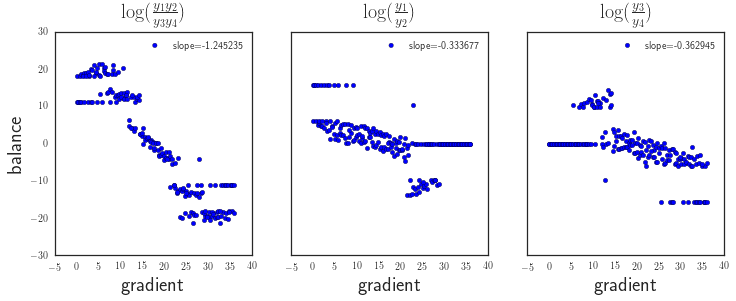

In [17]:
from scipy.stats import linregress
from matplotlib import rc
rc('text', usetex=True)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
y1 = microbial_table[:, 0] + 1e-6
y2 = microbial_table[:, 1] + 1e-6
y3 = microbial_table[:, 2] + 1e-6
y4 = microbial_table[:, 3] + 1e-6
b1 = np.log(np.sqrt((y1*y2)) / np.sqrt((y3*y4)))
b2 = np.log(y1/y2)/np.sqrt(2)
b3 = np.log(y3/y4)/np.sqrt(2)
s1 = linregress(gradient, b1)[0]
s2 = linregress(gradient, b2)[0]
s3 = linregress(gradient, b3)[0]
ax[0].scatter(gradient, b1, label='slope=%f' % s1)
ax[0].set_title(r'$\log(\frac{y_1 y_2}{y_3 y_4})$', fontsize=20, rotation=0)
ax[0].set_xlabel('gradient', fontsize=20)
ax[0].set_ylabel('balance', fontsize=20)
ax[0].legend()
ax[1].scatter(gradient, b2, label='slope=%f' % s2)
ax[1].set_title(r'$\log(\frac{y_1}{y_2})$', fontsize=20, rotation=0)
ax[1].set_xlabel('gradient', fontsize=20)
ax[1].legend()
ax[2].scatter(gradient, b3, label='slope=%f' % s3)
ax[2].set_title(r'$\log(\frac{y_3}{y_4})$', fontsize=20, rotation=0)
ax[2].set_xlabel('gradient', fontsize=20)
ax[2].legend()

Looks like the correlations still can be estimated, but the zeros will definitely be a problem.

# Packaging

We will now package the metadata and the biom tables for benchmarking

In [18]:
from biom import Table
from biom.util import biom_open
import pandas as pd

microbial_ids = ["Y%d" % i for i in range(microbial_table.shape[1])]
sample_ids = ["S%d" % i for i in range(microbial_table.shape[0])]

microbial_biom = Table(microbial_table.T, microbial_ids, sample_ids)

with biom_open('../data/simple-regression.biom', 'w') as f:  
    microbial_biom.to_hdf5(f, "microbes")

metadata = pd.DataFrame(metadata, index=sample_ids, columns=['intercept', 'confounder', 'gradient'])
metadata.to_csv('../data/metadata.txt', sep='\t')